# Probabilistic Principal Components Analysis (PPCA)

This notebook illustrate how to build and train a PPCA model using the [PPCA julia package](). More precisely, the package implements the ["Variational Principal Components Analysis"](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/bishop-vpca-icann-99.pdf).

In [5]:
using Pkg
Pkg.activate("../");

using LinearAlgebra
using Plots
using ExpFamilyDistributions
using Random

using Revise
using BayesianModels

using BasicDataLoaders

# Plotting function
include("plotting.jl");

 Activating environment at `~/GithubRepositories/PPCA/Project.toml`


## Synethic data

Our toy data is simply samples from a 2-dimensional Normal distribution

In [6]:
Random.seed!(100)

T = Float64
μ = T[1, 1] 
Σ = T[2. -.7; -.7  0.3]

function draw(n, μ, Σ)
    L = cholesky(Σ).L
    [μ + L*randn(T, 2) for i in 1:n] 
end

X = draw(30, μ, Σ)
dl = DataLoader(X, batchsize = 10)

DataLoader{Array{Array{Float64,1},1}}
  data: Array{Array{Float64,1},1}
  batchsize: 10

## Model

In [7]:
# Create the model
model = PPCA(T, datadim = 2, latentdim = 2, pstrength = 1e-3, W_MAP = true)

PPCA{Float64,2,2}:
  trans: AffineTransform{Float64,2,2}
  λ: BayesParam{Gamma{Float64},Gamma{Float64}}


## Training

The code below is only for plotting and it is not needed to use the model in practice. 

In [9]:
# Number of epochs for the training
epochs = 100

# For visualisation
anim = Animation()

# Training
elbos = []
function monitor(epoch)
    e = elbo(model, dl) 
    ND = length(X) * length(X[1])
    push!(elbos, e / ND)
    
    l = @layout [a b; c d]
    
    p1 = plot(legend = false, ylims = (-1,3), xlims = (-3, 5), title = "Observation space")
    scatter!(p1, getindex.(X, 1), getindex.(X, 2), mark = :cross, color = :blue)
    plotmodel!(p1, model)

    p3 = plot(xlabel = "epoch", xlims = (1, epochs), ylims = (-2, -1),
              color = :blue, legend = :bottomleft)
    plot!(p3, elbos,linewidth = 2, label = "ELBO")

    W = hcat([w.posterior.μ for w in model.trans.W]...)
    w₁ = W[1:end-1,:][1, :]
    w₂ = W[1:end-1,:][2, :]
    p4 = bar(["||w₁||²", "||w₂||²"], [norm(w₁), norm(w₂)],  ylims = (0,3),
             legend = false, color = :black, title = "norm. bases")

    hposts = X |> model 
    p2 = plot(legend = false, title = "Latent space", xlims = (-3, 3), ylims = (-3, 3))
    plotnormal2d!(p2, model.trans.hprior.μ, model.trans.hprior.Σ, color = :blue, linewidth = 2)
    plotnormals!(p2, hposts)

    plot(p1, p2, p3, p4, layout = l, size = (800, 500))
    
    frame(anim)
end

monitor (generic function with 1 method)

The actual training is done just by calling the function `fit!`. Note that `callback` is an optional argument and it is only for the user to monitor the convergence of the model. In this example, our callback is the `monitor` function which:
  * compute the ELBO of the data and the model
  * do some plotting  
  
This is of course time consuming and should be avoided in real cases. We recommend to use a simpler callback (if you want to use one) which computes the ELBO on a subset of the data every $K$ epochs. For instance, the callback can look like this:
```julia
function simplemonitor(epoch)
    # Compute the elbo every 5 epochs
    if epoch % 5 == 0 
        𝓛 = elbo(model, dl, θposts) 
        println("epoch = $e  𝓛 = $𝓛")
    end
end

fit!(model, dl, θposts, epochs = epochs, callback = simplemonitor)
```

┌ Info: Saved animation to 
│   fn = /home/lucas/GithubRepositories/PPCA/examples/demo.gif
└ @ Plots /home/lucas/.julia/packages/Plots/vsE7b/src/animation.jl:104


Plots.AnimatedGif("/home/lucas/GithubRepositories/PPCA/examples/demo.gif")
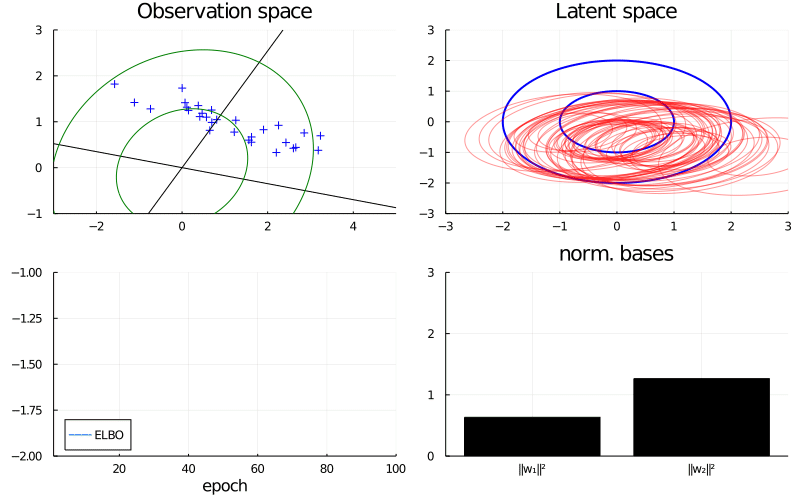

In [10]:
monitor(0) # Just to add the initialization of the model to the animation

# Training
# Internally, this function uses functionality of the
# Distributed package. If you want to accelerate the 
# training, call `addprocs(...)` to create more workers.
fit!(model, dl, epochs = epochs, callback = monitor)

gif(anim, "demo.gif", fps=5)